In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import sklearn

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

/Users/Kyelee/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# file_name = "SongCSV.csv"
# df = pd.read_csv(file_name)

In [3]:
# df = df.fillna(0)

In [4]:
list_columns = ["BarsConfidence", "BarsStart", "BeatsConfidence", "BeatsStart", "SectionsConfidence", "SectionsStart", 
                "SegmentsConfidence", "SegmentsLoudnessMax", "SegmentsLoudnessMaxTime", "SegmentsLoudnessMaxStart", "SegmentsPitches", 
                "SegmentsStart", "SegmentsTimbre", "TatumsConfidence", "TatumsStart"]

def transform_str_to_list(df, columns):
    for col in columns:
        all_cells = []
        
        # Modify each cell 
        for i in range(0, len(df[col])):
            
            # Get list
            horrid_string = df[col][i]
            
            # Remove non-float values
            pretty_string = horrid_string.replace("[", "").replace("]", "").replace("...", "")
            
            # Convert to a list of floats
            pretty_list = pretty_string.split()
            try:
                beautiful_list = np.array([float(el) for el in pretty_list])
            except:
                print(col, i)
                print(pretty_list)
            
            # Add to list of cells
            all_cells.append(beautiful_list)
        
        # Make it a new column
        df[col] = pd.Series(all_cells)

In [5]:
# transform_str_to_list(df, list_columns)

In [6]:
# df["BarsStart"][2]

In [7]:
from tqdm import tqdm

In [8]:
def mean_arrays(df, columns):
    for col in columns: 
        for i in tqdm(range(len(df[col]))):
            if len(df[col][i]) != 0:
                df[col][i] = np.mean(df[col][i])
            else:
                df[col][i] = 0
                
    return df

In [9]:
# mean_df = mean_arrays(df, list_columns)

In [10]:
# df.to_csv('average_df.csv')

In [11]:
# READING IN THE AVERAGE CSV FILE

df = pd.read_csv('average_df.csv')

In [12]:
df

,Unnamed: 0,SongNumber,SongID,AlbumID,AlbumName,ArtistFamiliarity,ArtistHotttnesss,ArtistID,ArtistLatitude,ArtistLocation,...,SegmentsStart,SegmentsTimbre,SongHotttnesss,TatumsConfidence,TatumsStart,Tempo,TimeSignature,TimeSignatureConfidence,Title,Year
0,0,1,b'SOGSMXL12A81C23D88',275907,b'Je Sais Que La Terre Est Plate (Deluxe)',0.557460,0.386152,b'AREJXK41187B9A4ACC',46.71067,b'France',...,69.930830,12.519750,0.547953,0.322668,71.025247,124.059,4,0.372,b'Je Sais Que La Terre Est Plate',2008
1,1,2,b'SOMBCOW12AAF3B229F',382807,b'Comme Vous',0.626958,0.434860,b'AR2XRFQ1187FB417FE',0.00000,b'',...,117.884180,-6.739667,0.475638,0.089049,123.792848,80.084,4,0.533,b'On Efface',2004
2,2,3,b'SOEYIHF12AB017B5F4',490659,b'Watkins Ale - Music of the English Renaissa...,0.425724,0.000000,b'ARODOO01187FB44F4A',0.00000,b'',...,33.192217,-1.989778,0.000000,0.222222,33.788618,54.874,4,0.000,b'Howells Delight',0
3,3,4,b'SODJYEC12A8C13D757',116616,"bDon't Worry Lady""""",0.611495,0.334520,b'ARJGW911187FB586CA',0.00000,b'',...,75.375229,20.706194,0.000000,0.093216,79.796557,77.150,3,0.369,b'Martha Served',2007
4,4,5,b'SOGSOUE12A58A76443',767122,b'Easy Listening: Cartoon Songs',0.367255,0.311616,b'AR9HQ6Y1187FB3C2CB',0.00000,b'',...,94.439833,-3.249000,0.000000,0.105013,98.247266,120.382,4,1.000,b'Zip-A-Dee-Doo-Dah (Song of the South)',0
5,5,6,b'SOVVDCO12AB0187AF7',503347,b'X Communication : Trilogy II',0.601306,0.363676,b'ARDPTGD1187B9AD361',36.87652,b'Sikeston MO',...,131.999917,29.385528,0.445455,0.117667,137.395212,99.024,4,1.000,b'Liquid Time (composition by John Goodsall)',0
6,6,7,b'SOKSZVC12A8C142004',239673,b'Karelian Isthmus',0.709011,0.553566,b'ARV8T9T1187B99F3F4',0.00000,b'',...,125.736411,16.607500,0.327737,0.055598,125.902267,175.673,4,0.000,b'Misery Path (From the Privilege of Evil)',0
7,7,8,b'SORWTIF12A6D4FAA41',124304,b'Nobilt\xc3\xa0 di strada',0.548022,0.440135,b'ARJ5BEW1187FB52361',0.00000,b'',...,129.511695,30.218944,0.000000,0.638083,129.601931,87.999,4,0.954,b'Nuovi Re pt. I I (feat. Tek money - Lady Tam...,0
8,8,9,b'SOZQSGL12AF72A9145',181162,b'Milking The Sacred Cow',0.737038,0.539245,b'AR050VJ1187B9B13A7',0.00000,b'',...,104.974765,-6.683333,0.788388,0.371667,106.796375,92.897,4,0.879,b'Halloween',1982
9,9,10,b'SOKRHNY12AB01837DB',337773,b'Novas Vos Trago',0.435915,0.358149,b'AR8KUS11187B98C991',0.00000,b'',...,155.704423,33.590389,0.000000,0.359269,156.336319,86.981,5,0.688,b'Parto em terras distantes',1998


In [13]:
df.columns

Index(['Unnamed: 0', 'SongNumber', 'SongID', 'AlbumID', 'AlbumName',
       'ArtistFamiliarity', 'ArtistHotttnesss', 'ArtistID', 'ArtistLatitude',
       'ArtistLocation', 'ArtistLongitude', 'ArtistName', 'BarsConfidence',
       'BarsStart', 'BeatsConfidence', 'BeatsStart', 'Danceability',
       'Duration', 'EndOfFadeIn', 'Energy', 'KeySignature',
       'KeySignatureConfidence', 'Loudness', 'Mode', 'ModeConfidence',
       'SectionsConfidence', 'SectionsStart', 'SegmentsConfidence',
       'SegmentsLoudnessMax', 'SegmentsLoudnessMaxTime',
       'SegmentsLoudnessMaxStart', 'SegmentsPitches', 'SegmentsStart',
       'SegmentsTimbre', 'SongHotttnesss', 'TatumsConfidence', 'TatumsStart',
       'Tempo', 'TimeSignature', 'TimeSignatureConfidence', 'Title', 'Year'],
      dtype='object')

In [14]:
df_dropped = df.drop(columns = ['Unnamed: 0', 'SongID', 'SongNumber', 'AlbumName', 'AlbumID', 'ArtistID', 
                              'ArtistLocation', 'Energy', 'ArtistName', 'Title', 'Energy'])

In [15]:
df_dropped

,ArtistFamiliarity,ArtistHotttnesss,ArtistLatitude,ArtistLongitude,BarsConfidence,BarsStart,BeatsConfidence,BeatsStart,Danceability,Duration,...,SegmentsPitches,SegmentsStart,SegmentsTimbre,SongHotttnesss,TatumsConfidence,TatumsStart,Tempo,TimeSignature,TimeSignatureConfidence,Year
0,0.557460,0.386152,46.71067,1.71819,0.136000,70.298204,0.647949,71.025470,0.0,148.74077,...,0.200528,69.930830,12.519750,0.547953,0.322668,71.025247,124.059,4,0.372,2008
1,0.626958,0.434860,0.00000,0.00000,0.163623,130.630938,0.346571,123.794350,0.0,252.99546,...,0.288250,117.884180,-6.739667,0.475638,0.089049,123.792848,80.084,4,0.533,2004
2,0.425724,0.000000,0.00000,0.00000,0.110357,30.497964,0.594763,33.789365,0.0,78.02730,...,0.245111,33.192217,-1.989778,0.000000,0.222222,33.788618,54.874,4,0.000,0
3,0.611495,0.334520,0.00000,0.00000,0.148167,79.627999,0.303867,79.666289,0.0,163.63057,...,0.545417,75.375229,20.706194,0.000000,0.093216,79.796557,77.150,3,0.369,2007
4,0.367255,0.311616,0.00000,0.00000,0.124979,97.253457,0.356867,98.247921,0.0,199.99302,...,0.262778,94.439833,-3.249000,0.000000,0.105013,98.247266,120.382,4,1.000,0
5,0.601306,0.363676,36.87652,-89.58828,0.089527,135.536193,0.353464,137.357465,0.0,279.35302,...,0.384139,131.999917,29.385528,0.445455,0.117667,137.395212,99.024,4,1.000,0
6,0.709011,0.553566,0.00000,0.00000,0.153945,125.384941,0.055598,125.902267,0.0,255.03302,...,0.487556,125.736411,16.607500,0.327737,0.055598,125.902267,175.673,4,0.000,0
7,0.548022,0.440135,0.00000,0.00000,0.195883,127.504819,0.840813,129.601779,0.0,259.31710,...,0.337500,129.511695,30.218944,0.000000,0.638083,129.601931,87.999,4,0.954,0
8,0.737038,0.539245,0.00000,0.00000,0.101561,106.156517,0.632656,107.442132,0.0,216.84200,...,0.362194,104.974765,-6.683333,0.788388,0.371667,106.796375,92.897,4,0.879,1982
9,0.435915,0.358149,0.00000,0.00000,0.096256,155.476639,0.353887,156.508410,0.0,312.99873,...,0.326917,155.704423,33.590389,0.000000,0.359269,156.336319,86.981,5,0.688,1998


In [16]:
songs = df_dropped.values
X = np.column_stack((songs[:, 0:1], songs[:, 2:]))
y = df_dropped.ArtistHotttnesss.values

In [17]:
print(X[0, :])
print(y)

print(type(X[0, 3]))

[ 5.57460220e-01  4.67106700e+01  1.71819000e+00  1.36000000e-01
  7.02982044e+01  6.47948980e-01  7.10254699e+01  0.00000000e+00
  1.48740770e+02  1.92000000e-01  0.00000000e+00  5.91000000e-01
 -9.63600000e+00  1.00000000e+00  5.56000000e-01  5.91333333e-01
  6.99308300e+01  5.76163701e-01 -1.22165125e+01  5.23497331e-02
 -1.92292384e+01  2.00527778e-01  6.99308300e+01  1.25197500e+01
  5.47952942e-01  3.22667802e-01  7.10252474e+01  1.24059000e+02
  4.00000000e+00  3.72000000e-01  2.00800000e+03]
[0.38615163 0.43485959 0.         ... 0.34524114 0.37374955 0.30584974]
<class 'numpy.float64'>


In [18]:
threshold = 0.4

y_new = [] 
for i in range(len(y)):
    if y[i] > threshold:
        y_new.append(1)
    else:
        y_new.append(0)

sum(y_new)

4166

In [19]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from sklearn import model_selection
from sklearn import preprocessing

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_new, test_size=0.33, random_state=42)

model_in = X_train.shape[1] # number of input neurons

model = Sequential()
model.add(Dense(60, input_dim = model_in, activation = 'relu'))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1, activation = 'relu'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                1920      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 3,161
Trainable params: 3,161
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
6700/6700 [==============================] - 1s 105us/step - loss: 8.0794 - acc: 0.4499


In [20]:
model.evaluate(X_test, y_test)

3300/3300 [==============================] - 0s 35us/step


[7.239197040904652, 0.5366666666666666]

/Users/Kyelee/anaconda3/lib/python3.6/site-packages/keras/engine/sequential.py:247: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


(0, 1)

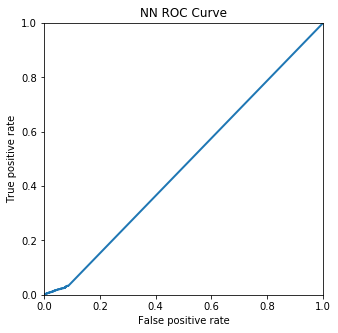

In [21]:
# ROC curve
from sklearn import metrics

probs = model.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, probs, pos_label=1, sample_weight=None)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, linewidth=2.0)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('NN ROC Curve')
plt.xlim([0,1])
plt.ylim([0,1])